<a href="https://colab.research.google.com/github/SewoongLee/addition_TF/blob/main/addition_TF_iter100k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math
import torch.nn.functional as F

class TF(nn.Module):
    def __init__(self, n_vocab=10, d_model=10):
        super(TF, self).__init__()

        self.WE = nn.Embedding(n_vocab, d_model)
        # self.WQ = nn.Linear(d_model, d_model, bias=False)
        # self.WK = nn.Linear(d_model, d_model, bias=False)
        # self.WV = nn.Linear(d_model, d_model, bias=False)
        self.W1 = nn.Linear(d_model, d_model, bias=False)
        # self.W2 = nn.Linear(d_model, d_model, bias=False)
        self.WL = nn.Linear(d_model, n_vocab, bias=False)

    def forward(self, x):
        batch_size, seq_len = x.shape
        E = self.WE(x) # E: (b, t, d_model)

        # Q = self.WQ(E)
        # K = self.WK(E)
        # att_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(E.size(-1))
        att_scores = torch.ones((seq_len, seq_len)) # No Q, K

        att_weight = F.softmax(att_scores, dim=-1).to(device)

        # V = self.WV(E)
        V = E # Ablate WV

        att = torch.matmul(att_weight, V)

        # FNN = self.W2(F.relu(self.W1(att)))
        FNN = F.relu(self.W1(att)) # Ablate W2
        # FNN = self.W1(att) # Ablate W2+ReLU (X)
        # FNN = att # Ablate FFN (X)

        L = self.WL(FNN)

        return L[:,-1,:] # only next token

In [3]:
inputs = []
labels = []

for i in range(10):
    for j in range(10):
        inputs.append([i, j])
        labels.append((i + j) % 10)

inputs = torch.LongTensor(inputs).to(device)
labels = torch.LongTensor(labels).to(device)

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model = TF().to(device)

print(sum(p.numel() for p in model.parameters()), 'parameters')

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

epochs = 100000
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_cnt = cnt = 0
    for batch, (x, y) in enumerate(dataloader):

        optimizer.zero_grad()

        pred = model(x)
        total_cnt += len(y)
        cnt += (torch.argmax(pred, dim=1) == y).count_nonzero()
        loss = loss_fn(pred, y)

        loss.backward()

        optimizer.step()
        with torch.no_grad():
          for param in model.parameters():
            param.clamp_(min=-1, max=1)

        total_loss += loss.item()
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}\t Loss: {total_loss/len(dataloader):4f}\t Acc: {cnt/total_cnt}")

300 parameters
Epoch 100	 Loss: 1.919503	 Acc: 0.4599999785423279
Epoch 200	 Loss: 1.528944	 Acc: 0.5299999713897705
Epoch 300	 Loss: 1.272630	 Acc: 0.7199999690055847
Epoch 400	 Loss: 1.102532	 Acc: 0.7899999618530273
Epoch 500	 Loss: 0.997166	 Acc: 0.7899999618530273
Epoch 600	 Loss: 0.915395	 Acc: 0.8100000023841858
Epoch 700	 Loss: 0.865364	 Acc: 0.8199999928474426
Epoch 800	 Loss: 0.830746	 Acc: 0.8799999952316284
Epoch 900	 Loss: 0.810599	 Acc: 0.8899999856948853
Epoch 1000	 Loss: 0.793321	 Acc: 0.8899999856948853
Epoch 1100	 Loss: 0.778401	 Acc: 0.8799999952316284
Epoch 1200	 Loss: 0.759630	 Acc: 0.8799999952316284
Epoch 1300	 Loss: 0.746501	 Acc: 0.8799999952316284
Epoch 1400	 Loss: 0.733061	 Acc: 0.8999999761581421
Epoch 1500	 Loss: 0.722835	 Acc: 0.9099999666213989
Epoch 1600	 Loss: 0.711797	 Acc: 0.9099999666213989
Epoch 1700	 Loss: 0.704479	 Acc: 0.8999999761581421
Epoch 1800	 Loss: 0.700582	 Acc: 0.8999999761581421
Epoch 1900	 Loss: 0.698202	 Acc: 0.8899999856948853
Epoch 

In [4]:
model.eval()
with torch.no_grad():
    pred = model(inputs)
    labels = torch.argmax(pred, dim=1)

err = 0
for i in range(100):
  if inputs[i].data.sum().item() % 10 != labels[i].item():
    err += 1
    print(inputs[i], labels[i])
print('Error: ', err)

tensor([2, 3], device='cuda:0') tensor(6, device='cuda:0')
tensor([3, 2], device='cuda:0') tensor(6, device='cuda:0')
tensor([3, 5], device='cuda:0') tensor(7, device='cuda:0')
tensor([3, 7], device='cuda:0') tensor(9, device='cuda:0')
tensor([5, 3], device='cuda:0') tensor(7, device='cuda:0')
tensor([7, 3], device='cuda:0') tensor(9, device='cuda:0')
Error:  6


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
def hm(data):
  sns.heatmap(data, annot=True, cmap='viridis', square=True, center=0, fmt='.1f')
  plt.show()

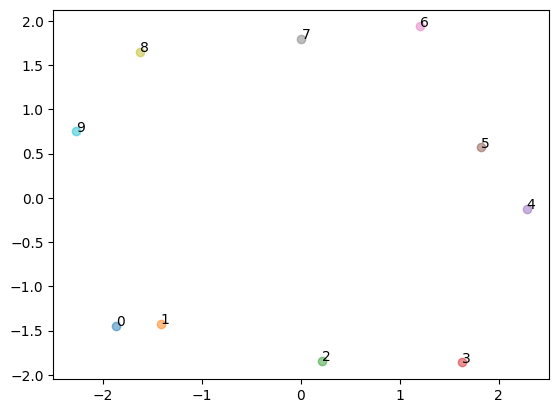

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(model.WE.weight.data.cpu().numpy())

for i, d in enumerate(pca_data):
  plt.scatter(d[0], d[1], alpha=0.5)
  plt.text(d[0], d[1], i)


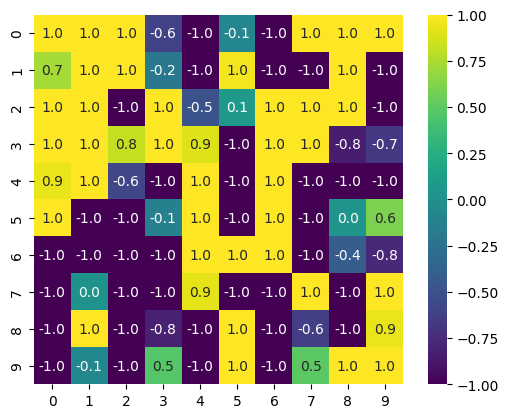

In [11]:
hm(model.WE.weight.data.cpu())

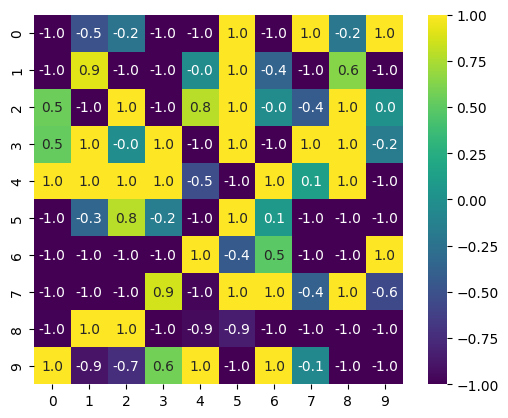

In [12]:
hm(model.W1.weight.data.cpu())

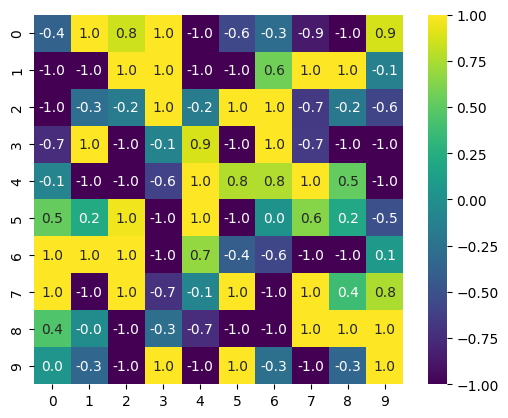

In [13]:
hm(model.WL.weight.data.cpu())

In [ ]:
import numpy as np

In [ ]:
input = '1'+'2'

In [ ]:
T = len(input)

In [ ]:
vocabs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

stoi = {s: i for i, s in enumerate(vocabs)}
itos = {i: s for i, s in enumerate(vocabs)}

stoi

In [ ]:
[stoi[s] for s in input]

In [ ]:
import numpy as np

W_emb = np.array([
    [0, ],  # 0
    [1, ],  # 1
    [2, ],  # 2
    [3, ],  # 3
    [4, ],  # 4
    [5, ],  # 5
    [6, ],  # 6
    [7, ],  # 7
    [8, ],  # 8
    [9, ],  # 9
], dtype=float)


assert W_emb.shape[0] == len(vocabs)
emb_dim = W_emb.shape[1]
W_emb.round()

In [ ]:
x = np.array([W_emb[stoi[token]] for token in input])
x

In [ ]:
head_count = 1
d_head = emb_dim
d_model = d_head * head_count
d_model

In [ ]:
W_Q = np.zeros((emb_dim, d_model))
W_K = np.zeros((emb_dim, d_model))
W_V = np.eye(d_model)*2

Q = x @ W_Q
K = x @ W_K
V = x @ W_V

assert Q.shape == (T, d_model)
assert K.shape == (T, d_model)
assert V.shape == (T, d_model)

In [ ]:
import torch

M = torch.triu(torch.ones(T, T) * float('-inf'), diagonal=1)
M = M.masked_fill(torch.isnan(M), 0).numpy()
M


In [ ]:
QK = (Q @ K.T) / np.sqrt(d_model)
weights = torch.softmax(torch.from_numpy(QK+M), dim=-1)
weights

In [ ]:
W_V

In [ ]:
x

In [ ]:
V

In [ ]:
Attention = weights @ V
Attention # Caveat: LayerNorm is not applied.

In [ ]:
# ff_dim = d_model
ff_dim = d_model * 4

W_1 = np.ones((d_model, ff_dim), dtype=float)
b_1 = np.zeros((ff_dim,), dtype=float)
print('W_1\n', W_1)
print('b_1\n', b_1)
assert W_1.shape == (d_model, ff_dim)
assert b_1.shape == (ff_dim,)

W_2 = np.ones((ff_dim, d_model), dtype=float) / ff_dim
b_2 = np.zeros((d_model,), dtype=float)
print('W_2\n', W_2)
print('b_2\n', b_2)
assert W_2.shape == (ff_dim, d_model)
assert b_2.shape == (d_model,)

FFN_X = torch.relu(torch.from_numpy(Attention.numpy() @ W_1 + b_1)) @ W_2 + b_2
assert FFN_X.shape == Attention.shape == (T, d_model)
print('FFN(X)\n', FFN_X.round())

In [ ]:
W_Z = np.ones((d_model, len(vocabs)), dtype=float)  # Last linear layer that converts to logits

In [ ]:
next_token_logits = (FFN_X @ W_Z)[-1]
next_token_logits

In [ ]:
next_token = itos[torch.argmax(torch.softmax(next_token_logits, dim=-1)).item()]
next_token

In [ ]:
# Result
print(f'input: {input} => next token: {next_token}')